In [1]:
# Start by downloading the Shiller dataset from Github
#import requests
#shiller_stream = requests.get("https://raw.githubusercontent.com/Huppie/DF-Simulations/master/data/SP500-Shiller.csv", stream=True)
#with open("SP500-Shiller.csv", 'wb') as f:
#    for chunk in shiller_stream.iter_content():
#        f.write(chunk)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.pyplot import figure
from functools import partial

datasets = {}

In [3]:
# Parse data from Shiller (1870 - now)
# http://www.econ.yale.edu/~shiller/data.htm
# Use this line when doing an on-line simulation with the data download lines above enabled:
#data = pd.read_csv("SP500-Shiller.csv", delimiter='\t')
# Otherwise, use the local file:
data = pd.read_csv("data/SP500-Shiller.csv", delimiter='\t')
data['Stock yield'] = data['P'].pct_change().fillna(0.0)
data['Div yield'] = (data['D'] / data['P']).fillna(0.0) / 12 # Shiller uses div yield of trailing 12 months
data['Inflation'] = data['CPI'].pct_change().fillna(0.0)
data['Yield'] =  data['Stock yield'] + data['Div yield']
datasets['Shiller'] = data[['Date', 'Div yield', 'Stock yield', 'Yield', 'Inflation']]

print("Data size for Shiller's S&P 500 data is %d" % len(data.index))
datasets['Shiller'].tail(5)

Data size for Shiller's S&P 500 data is 1773


,Date,Div yield,Stock yield,Yield,Inflation
1768,2018.05,0.001563,0.018036,0.019598,0.004159
1769,2018.06,0.001543,0.019567,0.021110,0.001594
1770,2018.07,0.001534,0.014265,0.015799,0.000067
1771,2018.08,0.001513,0.022974,0.024487,0.000556
1772,2018.09,0.001503,0.015285,0.016788,0.000278


In [4]:
dataset = datasets['Shiller']

def simulate_etf_buy(p, capital_start, etf_price_start, contribution, months, etf_ter=0.0025, etf_dividend_tax_leakage=0.1, dividend_cost_fn=None, accumulating=False):
    sample = dataset.iloc[p:p+months]
    
    etf_price = etf_price_start
    etfs = (capital_start - capital_start % etf_price) / etf_price
    cash = capital_start % etf_price
    
    dividends = 0
    for i in sample.index:
        # Step 1: We add the monthly contribution to our cash pool.
        cash += contribution
        
        # Step 2: ETF increases in price...
        etf_gain = etf_price * sample.at[i, 'Stock yield']
        # ... and costs are subtracted.
        etf_price = (etf_price + etf_gain) * (1 - etf_ter / 12)
        
        # Step 3: Accumulate dividends...
        if accumulating:
            # Accumulating dividends immediately affect the share price...
            gross_dividend_gain = etf_price * sample.at[i, 'Div yield']
            # ... but we still have to subtract unrecoverable dividend taxes (tax leakage.)
            net_dividend_gain = gross_dividend_gain * (1 - etf_dividend_tax_leakage)
            etf_price += net_dividend_gain
        else:
            dividends += etf_price * sample.at[i, 'Div yield']
            if i % 3 == 0:
                # ... and pay them out every quarter...
                gross_dividend = etfs * dividends
                # ... subtracting unrecoverable dividend taxes (tax leakage)...
                net_dividend = gross_dividend * (1 - etf_dividend_tax_leakage)
                if dividend_cost_fn:
                    # ... and dividend processing fees if applicable.
                    net_dividend = net_dividend - dividend_cost_fn(net_dividend)
                cash += net_dividend
                dividends = 0
        
        # Step 4: Buy ETFs from the available cash.
        etfs = etfs + (cash - cash % etf_price) / etf_price
        cash = cash % etf_price
    
    return cash + etfs * etf_price

def degiro_custody_dividend_cost(net_dividend):
    return min(net_dividend * 0.1, 1 + net_dividend * 0.03)

def simulate_etf_buys(initial_capital, initial_etf_price, monthly_contribution, duration_in_years=30, etf_ter=0.0025, etf_dividend_leakage=0.1, dividend_cost_fn=None, accumulating=False):
    months = duration_in_years * 12
    index = np.arange(0, len(dataset) - months)
    results = pd.Series((simulate_etf_buy(p, initial_capital, initial_etf_price, monthly_contribution, months, etf_ter, etf_dividend_leakage, dividend_cost_fn, accumulating) for p in index), index=index, name='end_value')
    return results

In [5]:
def simulate_fund_buy(p, capital_start, contribution, months, fund_front_cost=0.0025, fund_ter=0.005, dividend_tax_rate=0.15, accumulating=False, transaction_cost_fn=None):
    sample = dataset.iloc[p:p+months]
    
    fund_capital = capital_start * (1 - fund_front_cost)
    cash = 0
    dividends = 0
    withheld_dividend_taxes = 0
    for i in sample.index:
        # Step 1: We add the monthly contribution to our cash pool.
        cash += contribution
        
        # Step 2: Fund increases in price...
        fund_gain = fund_capital * sample.at[i, 'Stock yield']
        # ... and costs are subtracted.
        fund_capital = (fund_capital + fund_gain) * (1 - fund_ter / 12)
        
        # Step 3: Accumulate dividends (every december)
        if accumulating:
            fund_capital += fund_capital * sample.at[i, 'Div yield']
        else:
            dividends += fund_capital * sample.at[i, 'Div yield']
            if i % 12 == 0:
                # Pay out dividends once every year...
                gross_dividend = dividends
                # ... subtracting dividend taxes (although recoverable)...
                withheld_dividend_taxes = gross_dividend * dividend_tax_rate
                net_dividend = gross_dividend - withheld_dividend_taxes

                cash += net_dividend
                dividends = 0

            # Step 4: Get a tax refund every june
            if (i - 6) % 12 == 0:
                tax_refund = withheld_dividend_taxes
                withheld_dividend_taxes = 0

                cash += tax_refund
        
        # Step 5: Buy new funds from the available cash.
        if transaction_cost_fn:
            transaction_costs = transaction_cost_fn(cash)
            cash -= transaction_costs
        
        fund_capital = fund_capital + cash * (1 - fund_front_cost)
        cash = 0
     
    return fund_capital + withheld_dividend_taxes # Also return any open tax refund.

def simulate_fund_buys(initial_capital, monthly_contribution, duration_in_years=30, fund_front_cost=0.0025, fund_ter=0.005, dividend_tax_rate=0.15, accumulating=False, transaction_cost_fn=None):
    months = duration_in_years * 12
    index = np.arange(0, len(dataset) - months)
    results = pd.Series((simulate_fund_buy(p, initial_capital, monthly_contribution, months, fund_front_cost, fund_ter, dividend_tax_rate, accumulating, transaction_cost_fn) for p in index), index=index, name='end_value')
    return results

def lynx_transaction_costs(transaction_amount):
    return min(45, max(transaction_amount * 0.001, 6))

In [6]:
# Simulation for VWRL with startprice of 74.55 (August 2018) and monthly contribution of 1000 euros for 30 years.
vwrl_start_price = 74.55
iwda_start_price = 48.08
start_cash = 0
monthly_contribution = 500
num_years = 30

#%timeit -n1 -r1 res = simulate_etf_buys(start_cash, vwrl_start_price, monthly_contribution, num_years, dividend_cost_fn=degiro_custody_dividend_cost)
results_degiro_custody = simulate_etf_buys(start_cash, vwrl_start_price, monthly_contribution, num_years, dividend_cost_fn=degiro_custody_dividend_cost)
results_degiro_standard = simulate_etf_buys(start_cash, vwrl_start_price, monthly_contribution, num_years)
results_iwda = simulate_etf_buys(start_cash, iwda_start_price, monthly_contribution, num_years, etf_ter=0.0027, accumulating=True)

# Simulation for Meesman
#%timeit -n1 -r1 res =  simulate_fund_buys(start_cash, monthly_contribution, num_years)
results_meesman = simulate_fund_buys(start_cash, monthly_contribution, num_years)
results_actiam_at_binck = simulate_fund_buys(start_cash, monthly_contribution, num_years, fund_front_cost=0.0011, fund_ter=(0.0018 + 0.0015), accumulating=True)
results_actiam_at_lynx = simulate_fund_buys(start_cash, monthly_contribution, num_years, fund_front_cost=0.0011, fund_ter=0.0015, accumulating=True, transaction_cost_fn=lynx_transaction_costs)

In [7]:
q_25 = partial(pd.Series.quantile, q=0.25)
q_25.__name__ = '25%'
q_75 = partial(pd.Series.quantile, q=0.75)
q_75.__name__ = '75%'
percentiles_meesman = results_meesman.agg(['min', q_25, 'median', q_75, 'max'])
percentiles_degiro_standard = results_degiro_standard.agg(['min', q_25, 'median', q_75, 'max'])
percentiles_degiro_custody = results_degiro_custody.agg(['min', q_25, 'median', q_75, 'max'])
percentiles_actiam_at_binck = results_actiam_at_binck.agg(['min', q_25, 'median', q_75, 'max'])
percentiles_iwda = results_iwda.agg(['min', q_25, 'median', q_75, 'max'])
percentiles_actiam_at_lynx = results_actiam_at_lynx.agg(['min', q_25, 'median', q_75, 'max'])

In [12]:
# Output table of percentiles...
data = {}
data['meesman'] = percentiles_meesman
data['degiro standard'] = percentiles_degiro_standard
data['degiro custody'] = percentiles_degiro_custody
data['actiam.b'] = percentiles_actiam_at_binck
data['iwda'] = percentiles_iwda
data['actiam.l'] = percentiles_actiam_at_lynx


pd.options.display.float_format = '€ {:,.0f}'.format
results_meesman_vs_degiro_vs_actiam_percentiles = pd.DataFrame(data)
results_meesman_vs_degiro_vs_actiam_percentiles

,meesman,degiro standard,degiro custody,actiam.b,iwda,actiam.l
min,"€ 223,540","€ 217,233","€ 210,831","€ 242,116","€ 219,485","€ 247,834"
25%,"€ 551,782","€ 555,865","€ 541,737","€ 607,084","€ 556,324","€ 621,247"
median,"€ 764,143","€ 784,020","€ 766,995","€ 838,130","€ 786,459","€ 860,405"
75%,"€ 1,238,296","€ 1,271,241","€ 1,236,423","€ 1,375,679","€ 1,275,382","€ 1,415,576"
max,"€ 2,671,389","€ 2,759,560","€ 2,703,355","€ 2,935,108","€ 2,762,109","€ 3,016,336"


In [16]:
# Instead of using percentiles, ordering the data may be better.
ordered_meesman = results_meesman.sort_values()
ordered_meesman.index = range(1,len(ordered_meesman) + 1)
ordered_degiro_standard = results_degiro_standard.sort_values()
ordered_degiro_standard.index = range(1,len(ordered_degiro_standard) + 1)
ordered_degiro_custody = results_degiro_custody.sort_values()
ordered_degiro_custody.index = range(1,len(ordered_degiro_custody) + 1)
ordered_actiam_at_binck = results_actiam_at_binck.sort_values()
ordered_actiam_at_binck.index = range(1,len(ordered_actiam_at_binck) + 1)
ordered_iwda = results_iwda.sort_values()
ordered_iwda.index = range(1,len(ordered_iwda) + 1)
ordered_actiam_at_lynx = results_actiam_at_lynx.sort_values()
ordered_actiam_at_lynx.index = range(1,len(ordered_actiam_at_lynx) + 1)

In [17]:
# Create graph with actual ordered data...
data = {}
data['Meesman'] = ordered_meesman
data['DeGiro Standard'] = ordered_degiro_standard
data['DeGiro Custody'] = ordered_degiro_custody
data['Actiam @ Binck'] = ordered_actiam_at_binck
data['IWDA @ DeGiro'] = ordered_iwda
data['Actiam @ Lynx'] = ordered_actiam_at_lynx

results_meesman_vs_degiro_vs_actiam = pd.DataFrame(data)

Text(0.5, 0, 'Slechtste resultaat -> Beste resultaat')

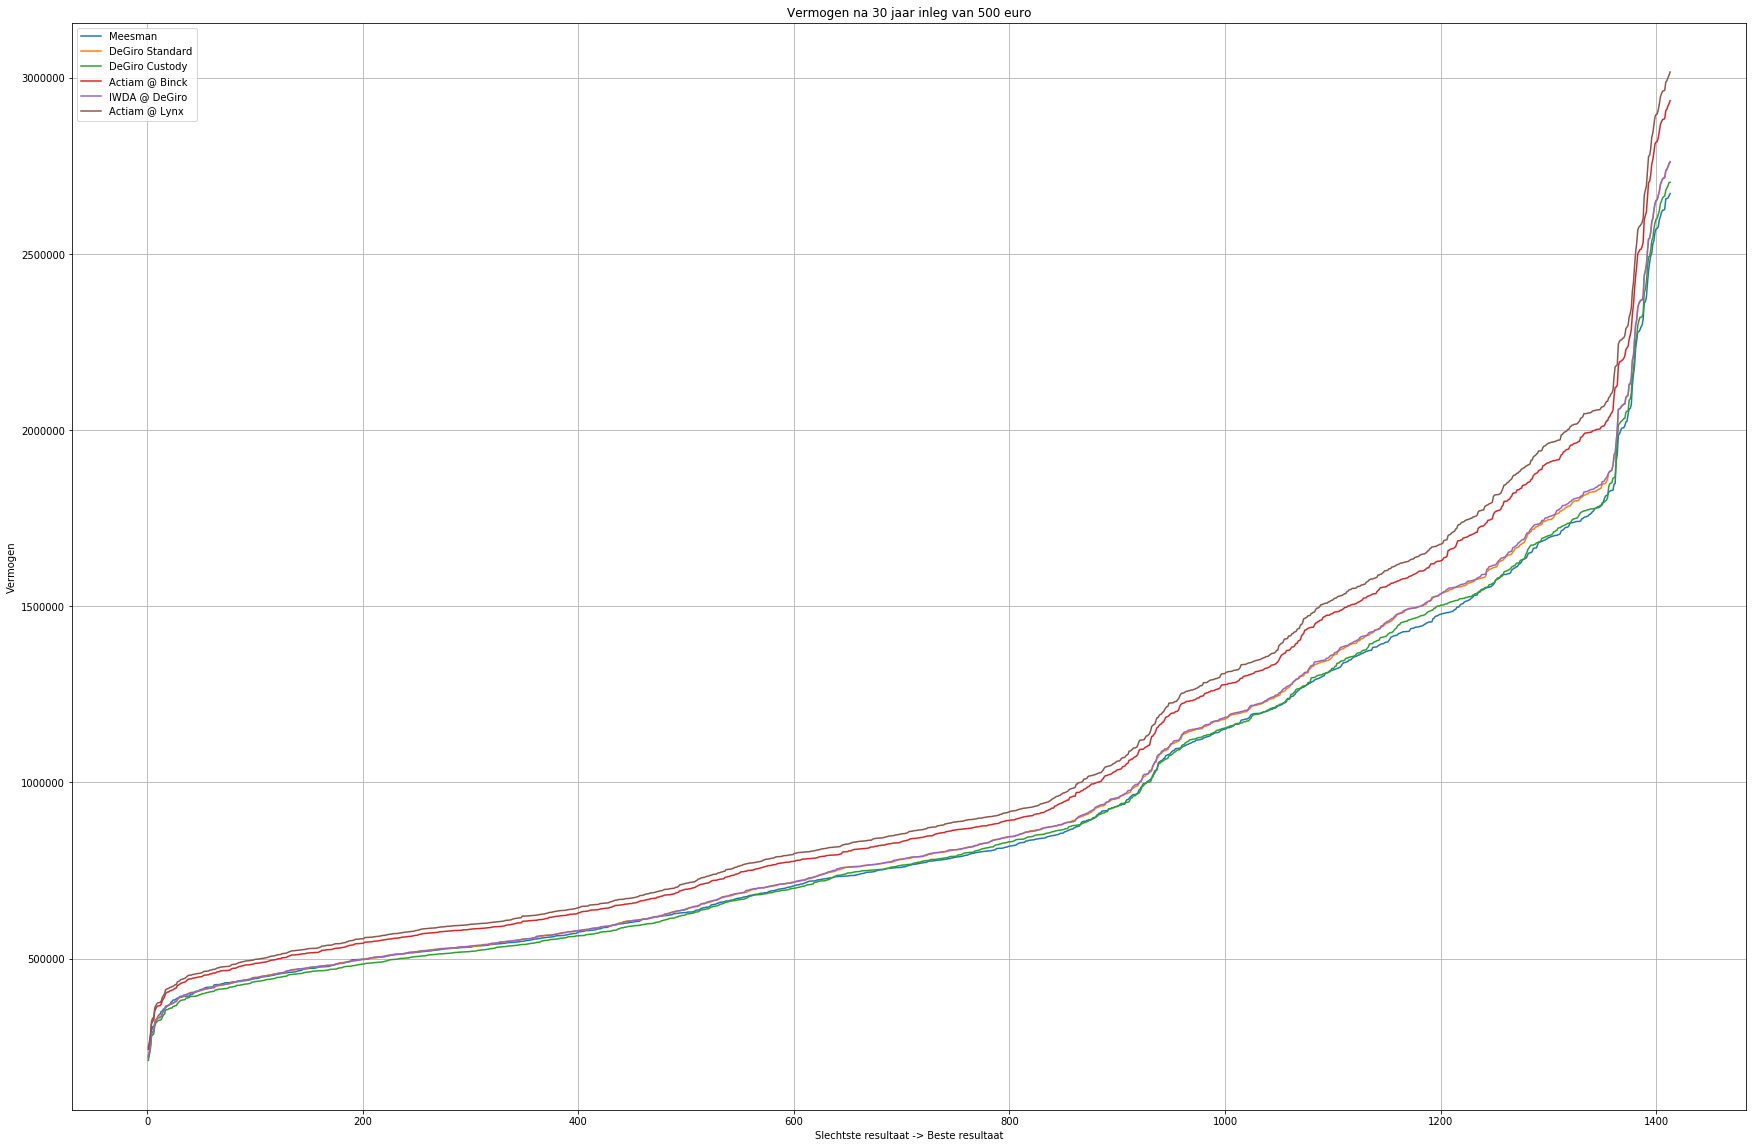

In [18]:
ax = results_meesman_vs_degiro_vs_actiam.plot(grid=True, title="Vermogen na 30 jaar inleg van 500 euro", figsize=[30,20])
ax.set_ylabel("Vermogen")
ax.set_xlabel("Slechtste resultaat -> Beste resultaat")

In [28]:
fig = ax.get_figure()
fig.savefig('30j_500.png')